# Data Science Regression Project: Predicting Home Prices in Udaipur

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

# Data Load: Load Udaipur home prices into a dataframe

In [2]:
df1 = pd.read_csv("Udaipur_house_data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Ekling pura,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Super built-up Area,Ready To Move,Titadi,2 BHk,Sector 9,1000,3.0,1.0,40.07
2,Super built-up Area,Ready To Move,Titadi,3 BHK,Sector 9,1000,2.0,1.0,41.04
3,Super built-up Area,Ready To Move,Titadi,4 BHK,Sector 9,1000,2.0,1.0,42.01
4,Super built-up Area,Ready To Move,Titadi,2 BHK,Sector 9,1500,3.0,2.0,60.00


In [3]:
df1.shape

(13347, 9)

In [4]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Super built-up Area', 'Plot  Area',
       'Built-up  Area', 'Carpet  Area'], dtype=object)

In [6]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Super built-up Area       27
Name: area_type, dtype: int64


Drop features that are not required to build our model

In [7]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape


(13347, 5)

# Data Cleaning: Handle NA values

In [8]:
df2.isnull().sum()

location       2
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df2.shape

(13347, 5)

In [10]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
df3.shape

(13272, 5)

# Feature Engineering


 Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [12]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

<ipython-input-12-681cf3aca53d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  3,  4,  5,  6,  1,  8,  7, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

Explore total_sqft feature

In [13]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [14]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
57,CA Circle,4 BHK,2100 - 2850,4.0,186.000,4
149,Balicha,4 BHK,3067 - 8156,4.0,477.000,4
164,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
192,Sobhagpura road,2 BHK,1145 - 1340,2.0,43.490,2
215,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
437,Keshav nagar,1 BHK,34.46Sq. Meter,1.0,18.500,1
576,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
675,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
688,Rk puram sector 9,2 BHK,1120 - 1145,2.0,48.130,2
699,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [15]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [16]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Ekling pura,2 BHK,1056.0,2.0,39.07,2
1,Titadi,2 BHk,1000.0,3.0,40.07,2


For below row, it shows total_sqft as 1056 which is an average of the range 1000-1500

In [17]:
df4.loc[30]

location      Sector 3
size             3 BHK
total_sqft        1521
bath                 3
price               95
bhk                  3
Name: 30, dtype: object

# Add new feature called price per square feet

In [18]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Ekling pura,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Titadi,2 BHk,1000.0,3.0,40.07,2,4007.000000
2,Titadi,3 BHK,1000.0,2.0,41.04,3,4104.000000
3,Titadi,4 BHK,1000.0,2.0,42.01,4,4201.000000
4,Titadi,2 BHK,1500.0,3.0,60.00,2,4000.000000


In [19]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.322600e+04
mean     7.912635e+03
std      1.066224e+05
min      2.678298e+02
25%      4.262295e+03
50%      5.428571e+03
75%      7.311746e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [20]:
df5.to_csv("bhp.csv",index=False)

Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [21]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Sector 4                                533
Sobhagpura road  Road                   391
Eklingpura                              301
Kanakpura Road                          263
Rk puram sector 9                       246
                                       ... 
Wheelers Road                             1
Goraguntepalya                            1
Prestige Sunrise                          1
Dhanalakshmi Layout                       1
Keshav nagar Satellite Town Stage II      1
Name: location, Length: 1321, dtype: int64

In [22]:
location_stats.values.sum()

13226

In [23]:
len(location_stats[location_stats>10])

239

In [24]:
len(location_stats)

1321

In [25]:
len(location_stats[location_stats<=10])

1082

# Dimensionality Reduction

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [26]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Sector 1 RSG layout                     10
BTM 1st Stage                           10
Gunjur Palya                            10
Basapura                                10
Naganathapura                           10
                                        ..
Wheelers Road                            1
Goraguntepalya                           1
Prestige Sunrise                         1
Dhanalakshmi Layout                      1
Keshav nagar Satellite Town Stage II     1
Name: location, Length: 1082, dtype: int64

In [27]:
len(df5.location.unique())


1321

In [28]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

240

In [29]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,other,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Titadi,2 BHk,1000.0,3.0,40.07,2,4007.000000
2,Titadi,3 BHK,1000.0,2.0,41.04,3,4104.000000
3,Titadi,4 BHK,1000.0,2.0,42.01,4,4201.000000
4,Titadi,2 BHK,1500.0,3.0,60.00,2,4000.000000
5,Titadi,3 BHK,1500.0,4.0,62.23,3,4148.666667
6,Titadi,4 BHK,1500.0,3.0,63.00,4,4200.000000
7,Titadi,3 BHK,2000.0,4.0,93.42,3,4671.000000
8,Titadi,4 BHK,2000.0,3.0,95.00,4,4750.000000
9,Titadi,5 BHK,2000.0,3.0,96.00,5,4800.000000


# Outlier Removal Using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft



In [30]:
df5[df5.total_sqft/df5.bhk<300].head()


,location,size,total_sqft,bath,price,bhk,price_per_sqft
3,Titadi,4 BHK,1000.0,2.0,42.01,4,4201.000000
12,other,4 BHK,1000.0,2.0,33.00,4,3300.000000
21,other,4 BHK,1000.0,2.0,43.00,4,4300.000000
36,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804
72,other,8 Bedroom,600.0,9.0,200.00,8,33333.333333


Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [31]:
df5.shape

(13226, 7)

In [32]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12479, 7)

# Outlier Removal Using Standard Deviation and Mean 

In [33]:
df6.price_per_sqft.describe()

count     12479.000000
mean       6303.822040
std        4165.754708
min         267.829813
25%        4204.689902
50%        5290.322581
75%        6911.166906
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [34]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10286, 7)

Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

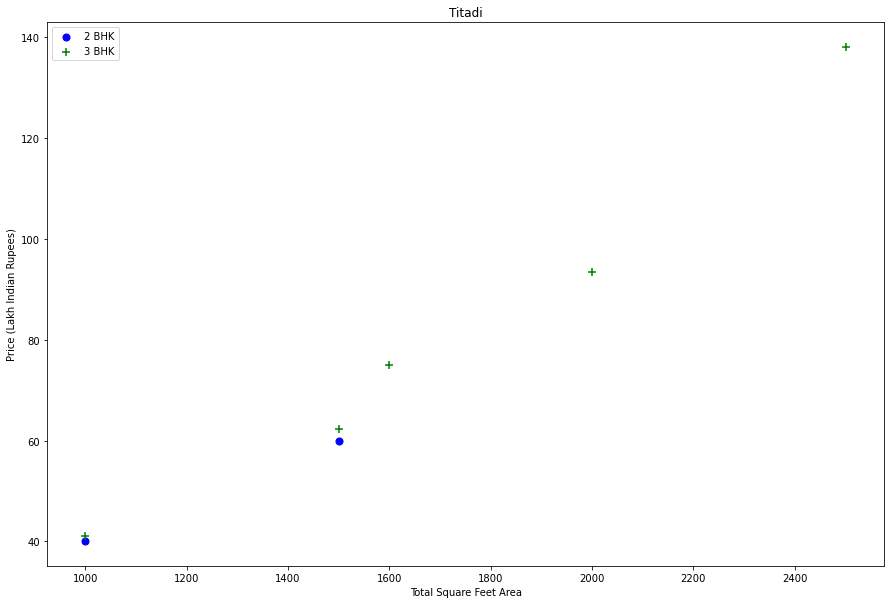

In [35]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Titadi")


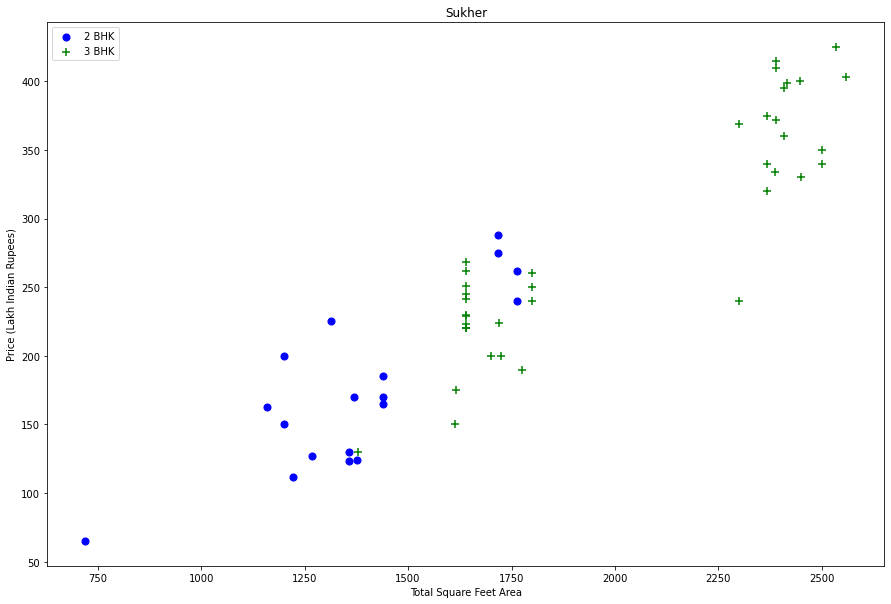

In [36]:
plot_scatter_chart(df7,"Sukher")

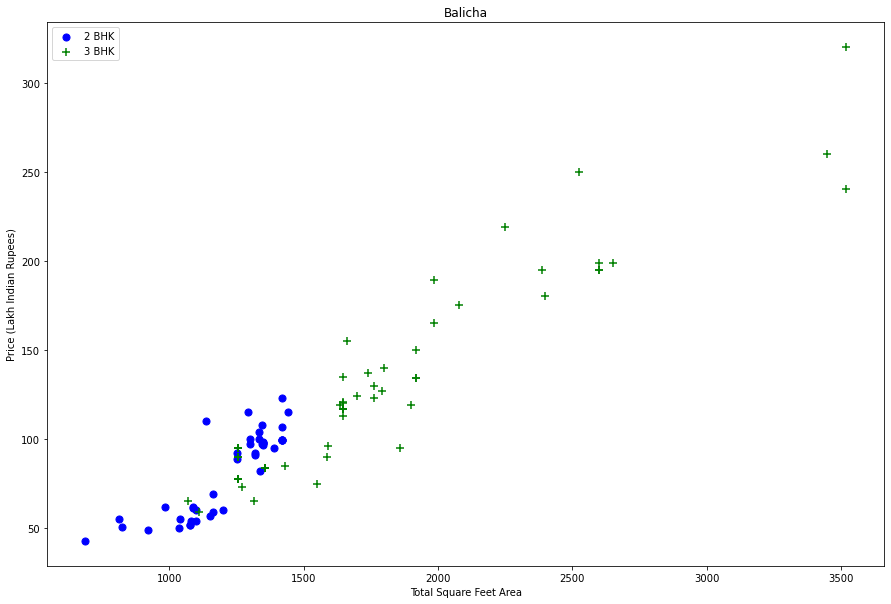

In [37]:
plot_scatter_chart(df7,"Balicha")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}


 Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment



In [38]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7349, 7)

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

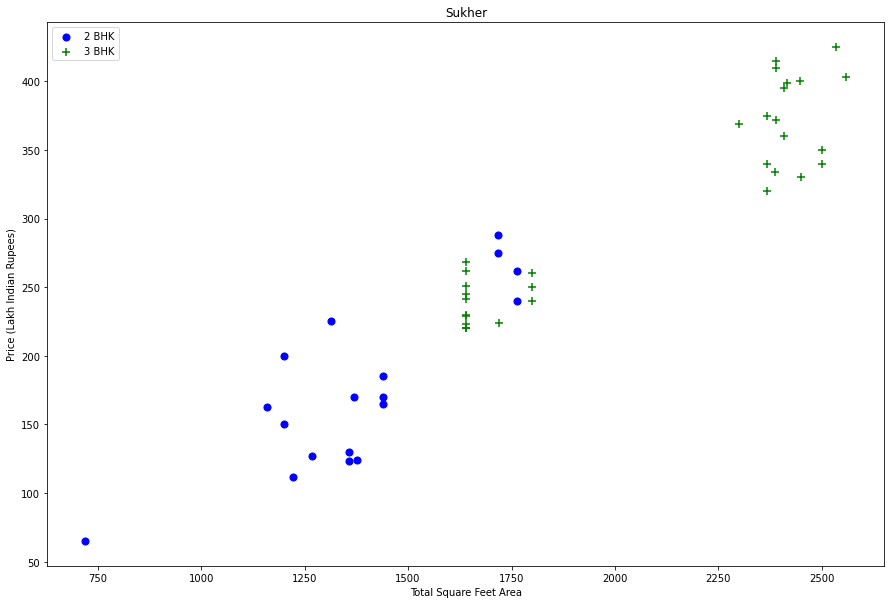

In [39]:
plot_scatter_chart(df8,"Sukher")

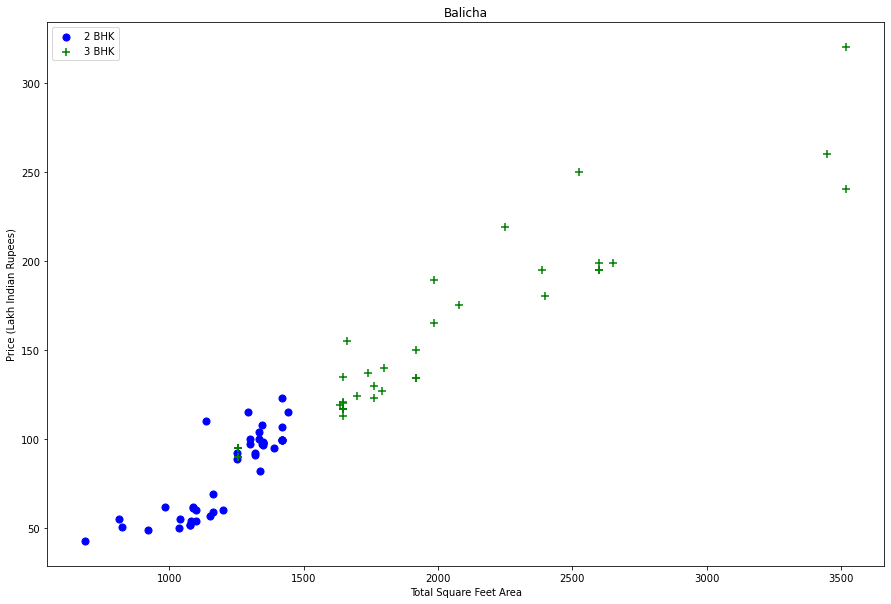

In [40]:
plot_scatter_chart(df8,"Balicha")

Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function

Text(0, 0.5, 'Count')

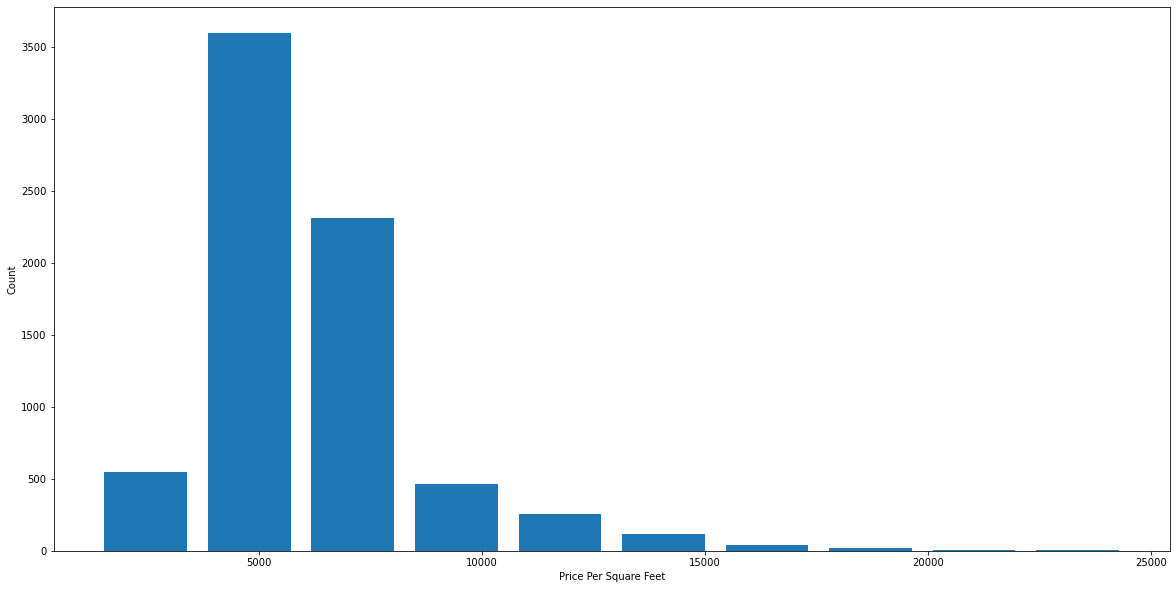

In [41]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

# Outlier Removal Using Bathrooms Feature

In [42]:
df8.bath.unique()

array([ 3.,  5.,  4.,  2.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

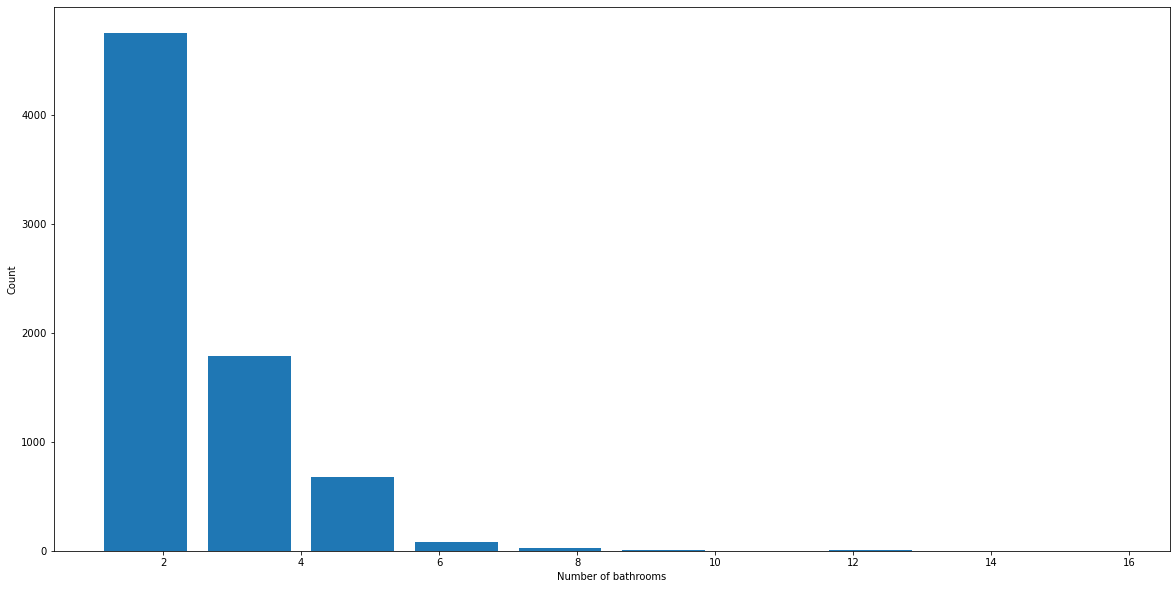

In [43]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")


In [44]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
6880,Sector 8,10 BHK,4000.0,12.0,160.0,10,4000.000000
8530,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8618,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9351,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9682,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [45]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
317,Airport sites,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
1973,Chandpole,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5648,Police line,3 BHK,1806.0,6.0,116.0,3,6423.034330
8455,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [46]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7270, 7)

In [47]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1,1st Phase JP Nagar,3 BHK,1875.0,3.0,167.0,3,8906.666667
2,1st Phase JP Nagar,5 Bedroom,1500.0,5.0,85.0,5,5666.666667


In [48]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
1,1st Phase JP Nagar,1875.0,3.0,167.0,3
2,1st Phase JP Nagar,1500.0,5.0,85.0,5
3,1st Phase JP Nagar,2065.0,4.0,210.0,3


 Use One Hot Encoding For Location

In [49]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Yelachenahalli,Yelenahalli,Yeshwanthpur,other
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Yelachenahalli,Yelenahalli,Yeshwanthpur
1,1st Phase JP Nagar,1875.0,3.0,167.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Phase JP Nagar,1500.0,5.0,85.0,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Phase JP Nagar,2065.0,4.0,210.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1st Phase JP Nagar,2059.0,3.0,225.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1st Phase JP Nagar,1394.0,2.0,100.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Yelachenahalli,Yelenahalli,Yeshwanthpur
1,1875.0,3.0,167.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1500.0,5.0,85.0,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Build a Model Now...

In [52]:
df12.shape

(7270, 243)

In [53]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,...,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Yelachenahalli,Yelenahalli,Yeshwanthpur
1,1875.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1500.0,5.0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2065.0,4.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X.shape

(7270, 242)

In [55]:
y = df12.price
y.head(3)

1    167.0
2     85.0
3    210.0
Name: price, dtype: float64

In [56]:
len(y)

7270

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [58]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8426730207993325

# Using K Fold cross validation to measure accuracy of our LinearRegression model

In [59]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.83114699, 0.78339305, 0.77201481, 0.86662861, 0.83473004])

We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

# Find best model using GridSearchCV

In [60]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.817583,{'normalize': False}
1,lasso,0.703527,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.665978,"{'criterion': 'mse', 'splitter': 'random'}"



Based on above results we can say that LinearRegression gives the best score. Hence we will use that.

# Test the model for few properties

In [61]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [62]:
predict_price('Titadi',1000, 2, 2)

21.89284666541559

In [63]:
predict_price('Titadi',1000, 3, 3)

25.246309717410867

In [64]:
predict_price('Keshav nagar',1000, 2, 2)

45.21880606754681

In [65]:
predict_price('Bedla udaipur',1000, 3, 3)

189.36571260971823

# Export the tested model to a pickle file

In [66]:
import pickle
with open('Udaipur_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

Export location and column information to a file that will be useful later on in our prediction application

In [67]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))